In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from bandit_sim.common import Reward, Action
from icecream import ic

In [4]:
result_dir = "20250813-1037-alignment"
output_dir = os.path.join("../output/", result_dir)

# config
T = 1000000
trials = range(10)
algs = ["TS-ep1", "TS-ep2"]
K = 32
base_seed = 1111

num_trials = len(trials)
num_algs = len(algs)
K = 32
K_env = K // 2

all_regrets = np.zeros((num_trials, num_algs, T), dtype=Reward)
all_actions = np.zeros((num_trials, num_algs, T), dtype=Action)


def generate_base_filename(base_seed: int, trial_id: int, alg_label: str) -> str:
    return f"{alg_label}_seed{base_seed}_id{trial_id}.npy"


for i, trial_id in enumerate(trials):
    for alg in algs:
        filename = generate_base_filename(base_seed, trial_id, alg)
        with open(os.path.join(output_dir, f"regrets_{filename}"), "rb") as f:
            all_regrets[i] = np.load(f)
        with open(os.path.join(output_dir, f"actions_{filename}"), "rb") as f:
            all_actions[i] = np.load(f)

In [13]:
selected_alg = 0

regrets_IDS = all_regrets[:, selected_alg, :]
actions_IDS = all_actions[:, selected_alg, :]

In [14]:
env_actions = (actions_IDS < 16).astype(int)
human_actions = 1 - env_actions

cum_env_actions = np.cumsum(env_actions, axis=1)
cum_human_actions = np.cumsum(human_actions, axis=1)

/var/folders/b4/p5yky4js5cs379v1t5vsgv8m0000gn/T/ipykernel_81134/1243628275.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


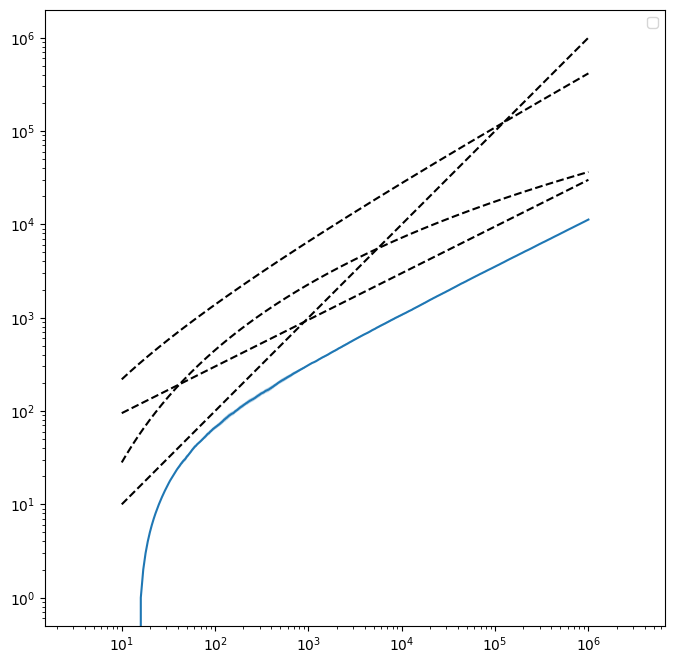

In [15]:
plt.figure(figsize=(8, 8))
for i in range(len(all_actions)):
    # plt.plot(np.arange(T), cum_human_actions[i], color="red", alpha=0.3)
    # plt.plot(np.arange(T), cum_human_actions[i], label=i, alpha=0.8)
    ...

plt.plot(np.arange(10, T, 1), np.mean(cum_human_actions, axis=0)[10:])
plt.fill_between(
    np.arange(10, T, 1),
    np.mean(cum_human_actions, axis=0)[10:] + np.std(cum_human_actions, axis=0)[10:],
    np.mean(cum_human_actions, axis=0)[10:] - np.std(cum_human_actions, axis=0)[10:],
    alpha=0.3,
)

sqrt_t = np.sqrt(np.arange(10, T, 1))
sqrt_t_log_t = np.sqrt(np.arange(10, T, 1)) * np.log(np.arange(10, T, 1))
log_t = np.log(np.arange(10, T, 1)) * np.log(np.arange(10, T, 1))

plt.plot(np.arange(10, T, 1), np.arange(10, T, 1), color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), 30 * sqrt_t_log_t, color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), log_t**2, color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), 30 * sqrt_t, color="black", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.legend()
plt.show()

In [16]:
actions = actions_IDS[2]

In [17]:
unique, counts = np.unique(actions, return_counts=True)

for i in range(16):
    ic(f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}")

n_h = sum(counts[16:])
n_env = sum(counts[:16])
ic(n_h)
ic(f"proportion: {n_h / (n_h + n_env)}")

ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '0: 979617		 0h: 11023'
ic| f"{i}: {counts[i]}

\t\t {i}h: {counts[i + 16]}": '1: 31		 1h: 7'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '2: 81		 2h: 11'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '3: 58		 3h: 7'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '4: 29		 4h: 16'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '5: 259		 5h: 15'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '6: 3228		 6h: 87'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '7: 71		 7h: 9'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '8: 87		 8h: 9'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '9: 3968		 9h: 115'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '10: 40		 10h: 21'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '11: 413		 11h: 24'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '12: 44		 12h: 4'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '13: 130		 13h: 14'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '14: 56		 14h: 13'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i 

'proportion: 0.011403'

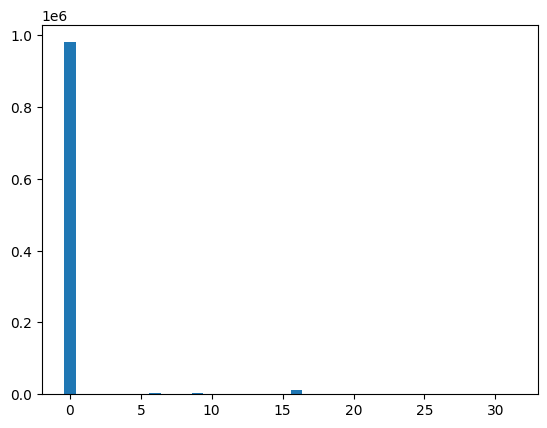

In [18]:
plt.bar(unique, counts)
plt.show()